# Exploring Hugging Face Accelerate with `xaitk-saliency` Integration

This example explores integrating `xaitk-saliency` and Hugging Face Accelerate with multi-GPU based inference.

## Table of Contents

* [Environment Setup](#environment-setup)
* [Imports](#imports)
* [`xaitk-saliency` Integration](#xaitk-integration)
  * [Defining the "Application"](#defining-the-application)
  * [Black-Box Classifer](#black-box-classifier)
  * [Saliency Generator](#saliency-generator)
  * [Generate Saliency Maps](#generate-saliency-maps)
  * [Results Comparison](#results-comparison)

## Environment Setup <a name="environment-setup"></a>

In [1]:
import sys
!{sys.executable} -m pip install -qU pip
print("Installing xaitk-cdao...")
!{sys.executable} -m pip install -q ../..
print("Installing xaitk-saliency...")
!{sys.executable} -m pip install -q xaitk-saliency
print("Installing smqtk-classifier...")
!{sys.executable} -m pip install -qU smqtk-classifier
print("Installing Hugging Face datasets...")
!{sys.executable} -m pip install -q datasets
print("Installing Hugging Face transformers...")
!{sys.executable} -m pip install -q transformers
print("Installing Hugging Face accelerate...")
!{sys.executable} -m pip install -q accelerate
print("Done!")

Installing xaitk-cdao...
Installing xaitk-saliency...
Installing smqtk-classifier...
Installing Hugging Face datasets...
Installing Hugging Face transformers...
Installing Hugging Face accelerate...
Done!


In [2]:
# Note PREDICT_SIZE should be >= BATCH_SIZE, due to the way Accelerate distributes data
BATCH_SIZE = 1
PREDICT_SIZE = 2
MASKED_DATA_BATCH_SIZE = 128
NUM_PROCESSES = 1

## Imports <a name="imports"></a>

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
# Use JPEG format for inline visualizations
%config InlineBackend.figure_format = "jpeg"

import numpy as np
import time
import torch
from torch.utils.data import Dataset, DataLoader, IterableDataset, get_worker_info
from torchvision import transforms
from datasets import load_dataset
from transformers import AutoModelForImageClassification
from accelerate import Accelerator, notebook_launcher
from accelerate.utils import set_seed

from scipy.special import softmax
from typing import Iterable, Optional
from smqtk_classifier.interfaces.classify_image import ClassifyImage
from xaitk_saliency.impls.gen_image_classifier_blackbox_sal.slidingwindow import SlidingWindowStack
from xaitk_saliency.interfaces.gen_image_classifier_blackbox_sal import GenerateImageClassifierBlackboxSaliency

# For "artifact tracking" (to compare results)
import pickle

## `xaitk-saliency` Integration <a name="xaitk-integration"></a>

### Defining the "Application" <a name="defining-the-application"></a>

To use Hugging Face Accelerate within a notebook, we must be careful to avoid initializing CUDA as it can only be initialized once. We'll wrap all our main functionality in a function that we'll call via `notebook_launcher` to avoid this.

In [4]:
def app(
    saliency_generator: GenerateImageClassifierBlackboxSaliency,
    use_accelerate: bool = True,
    display_results: bool = False,
    results_filepath: Optional[str] = None
):  
    class TestDataset(Dataset):
        def __init__(self, data):
            self.data = data
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                transforms.Resize((224, 224), antialias=True),
            ])

        def __getitem__(self, index):
            return self.transform(self.data[index])

        def __len__(self):
            return len(self.data)
    
    accelerator = None
    if use_accelerate:
        # For reproducability
        set_seed(42)

        # Set up the accelerator
        accelerator = Accelerator(even_batches=False)
    
    # Get the model
    model_name = "aaraki/vit-base-patch16-224-in21k-finetuned-cifar10"
    model = AutoModelForImageClassification.from_pretrained(model_name)
    
    # Predicting on a subset of the CIFAR10 Test dataset
    ds = load_dataset("cifar10", split="test")
    labels = ds.features['label'].names
    num_classes = len(labels)
    ds_shuffle = ds.shuffle(seed=42)
    images = ds_shuffle[0:PREDICT_SIZE]['img']
    dataloader = DataLoader(TestDataset(images), batch_size=min(BATCH_SIZE, PREDICT_SIZE))
    
    if accelerator:
        # Prepare the model and dataloader for use with accelerate
        model, dataloader = accelerator.prepare(model, dataloader)
        
    image_classifier = AccelerateClassifier(
        model,
        labels,
        accelerator, 
        transform=None
    )
        
    # Generate saliency maps
    sal_maps_set = []
    for batch in dataloader:
        b = batch.cpu().data.numpy()
        for img in b:
            sal_maps = saliency_generator(np.moveaxis(img, 0, -1), image_classifier)
            sal_maps_set.append(sal_maps)
       
    # Gather results from across devices
    if accelerator:
        accelerator.wait_for_everyone()
        t_sal_maps_set = torch.Tensor(np.array(sal_maps_set)).to(accelerator.device)
        sal_maps_set_gathered = accelerator.gather(t_sal_maps_set)
        sal_maps_set_gathered = sal_maps_set_gathered.data.cpu().numpy()
    else:
        sal_maps_set_gathered = sal_maps_set
        
    # Plot each image in set with saliency maps
    if display_results and (accelerator is None or accelerator.is_main_process):
        for i in range(len(images)):
            plt.figure(figsize=(10,5))
            num_cols = np.ceil(num_classes/2).astype(int) + 1
            plt.subplot(2, num_cols, 1)
            plt.imshow(images[i], cmap='gray')
            plt.xticks(())
            plt.yticks(())

            for c in range(num_cols - 1):
                plt.subplot(2, num_cols, c + 2)
                plt.imshow(sal_maps_set_gathered[i][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)
                plt.xticks(())
                plt.yticks(())
                plt.xlabel(f"{labels[c]}")
            for c in range(num_classes - num_cols + 1, num_classes):
                plt.subplot(2, num_cols, c + 3)
                plt.imshow(sal_maps_set_gathered[i][c], cmap=plt.cm.RdBu, vmin=-1, vmax=1)
                plt.xticks(())
                plt.yticks(())
                plt.xlabel(f"{labels[c]}")
                
    # Save results for comparison for examples sake
    if results_filepath is not None and (accelerator is None or accelerator.is_main_process):
        pickle.dump(sal_maps_set_gathered, open(results_filepath, "wb")) 

### Black-Box Classifier <a name="black-box-classifier"></a>

To use the selected model with the `GenerateImageClassifierBlackboxSaliency` interface, we need to create an implementation of `ClassifyImage` that wraps the underlying model. The core method that requires implementation is `classify_images()` which takes images and returns predictions for each image in the format defined by the interface.

We'll also define an `IterableDataset` to operate on the masked dataset in batches.

In [5]:
class AccelerateClassifier(ClassifyImage):
    def __init__(
        self,
        model: torch.nn.Module,
        labels: list,
        accelerator: Optional[Accelerator]=None, 
        transform: Optional[transforms.transforms.Compose]=None,
    ):
        self.model = model
        self.accelerator = accelerator
        self.labels = labels
        self.transform = transform
    
    def get_labels(self):
        return self.labels
    
    class ClassifyImagesDataset(IterableDataset):
        def __init__(self,
                     iterable: Iterable[np.ndarray],
                     device = None,
                     transform: Optional[transforms.transforms.Compose]=None):
            self._iterable = iterable
            self._device = device
            self._transform = transform
        
        def __iter__(self):
            tnsfm = self._transform
            device = self._device
            
            for image in self._iterable:
                image = np.moveaxis(image, -1, 0)
                if tnsfm:
                    item = tnsfm(image)
                else:
                    item = image
                if device:
                    item = torch.Tensor(item).to(device)
                yield item

    def classify_images(self, image_iter):
        dataloader = DataLoader(
            self.ClassifyImagesDataset(
                image_iter, 
                self.accelerator.device if self.accelerator else None
                ), 
            batch_size=MASKED_DATA_BATCH_SIZE,
            shuffle=False,
        )
        
        self.model.eval()
        results = []
        for batch in dataloader:
            with torch.no_grad():
                preds = softmax(self.model(batch).logits.data.cpu().numpy(), axis=1)
            results.extend([{la: p for p, la in zip(pred, self.labels)} for pred in preds])
            
        return results
            
    # Required for implementation
    def get_config(self):
        return {}

### Saliency Generator <a name="saliency-generator"></a>

We create an instance of `SlidingWindowStack`, an implementation of the `GenerateImageClassifierBlackboxSaliency` interface, to carry out our image pertubation and heatmap generation. 

The images will already be normalized when the saliency generator gets the image, so we don't need to set a fill value here.

In [6]:
gen_sliding_window = SlidingWindowStack(
    window_size=(14, 14),
    stride=(7, 7),
    threads=4
)

### Generate Saliency Maps <a name="generate-saliency-maps"></a>

We can now use the `notebook_launcher` interface to carry out our distributed saliency map generation. [Accelerate documentation](https://huggingface.co/docs/accelerate/v0.11.0/en/launcher) has more information about the notebook launcher.

Launching training on one GPU.


Found cached dataset cifar10 (/home/local/KHQ/emily.veenhuis/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
Loading cached shuffled indices for dataset at /home/local/KHQ/emily.veenhuis/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-6d58bc2a635b7b42.arrow


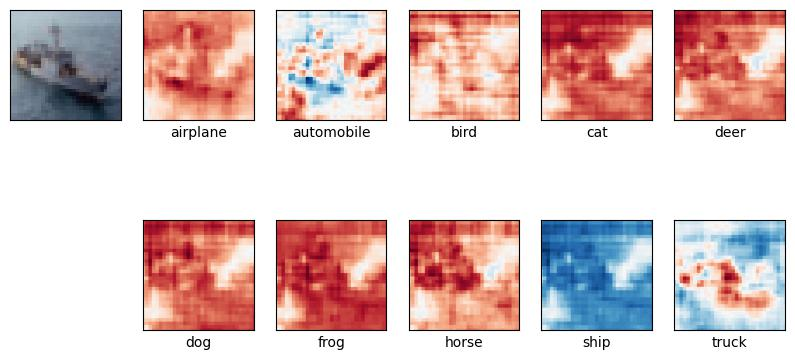

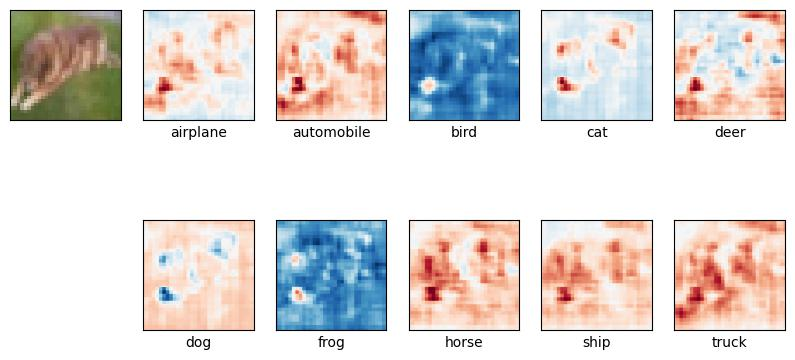

In [7]:
args = (
    gen_sliding_window,    
    True,                  # use_accelerate
    True,                  # display_results
    "with_accelerate.pkl", # results_filepath
)
notebook_launcher(app, args, num_processes=NUM_PROCESSES)

We'll also generate saliency maps without Accelerate, to confirm results are the same with/without scaling:

Found cached dataset cifar10 (/home/local/KHQ/emily.veenhuis/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
Loading cached shuffled indices for dataset at /home/local/KHQ/emily.veenhuis/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4/cache-6d58bc2a635b7b42.arrow


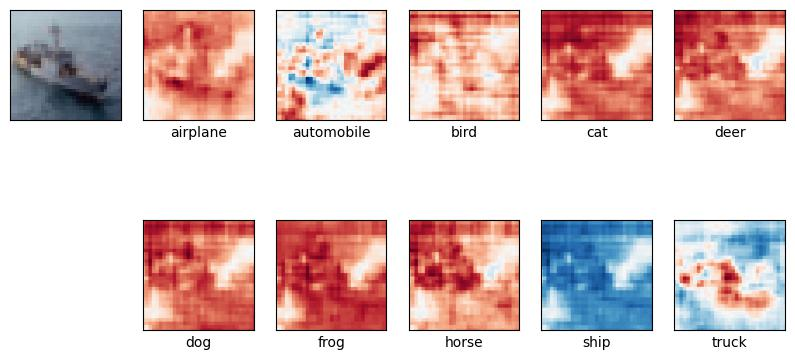

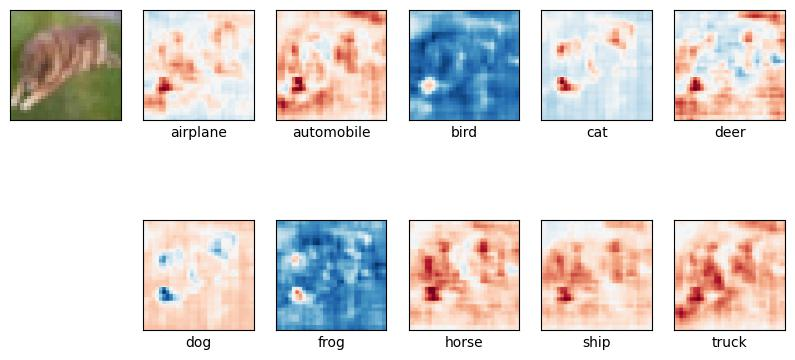

In [8]:
app(
    gen_sliding_window, 
    use_accelerate=False, 
    display_results=True, 
    results_filepath="wo_accelerate.pkl",
)

### Results Comparison <a name="results-comparison"></a>

We can see, via visual inspection, that the saliency maps produced are consistent across both methods, as expected. We can also confirm this numerically:

In [9]:
with_accelerate = pickle.load(open("with_accelerate.pkl", "rb"))
wo_accelerate = pickle.load(open("wo_accelerate.pkl", "rb"))

allclose = [True]*len(with_accelerate)
for idx, compare in enumerate(zip(with_accelerate, wo_accelerate)):
    for w, wo in zip(compare[0], compare[1]):
        # Normalize data
        w = (w-np.min(w))/(np.max(w)-np.min(w))
        wo = (wo-np.min(wo))/(np.max(wo)-np.min(wo))

        if not np.allclose(w, wo, atol=1e-02):
            allclose[idx] = False
            break
print(allclose)
assert(all(allclose))

[True, True]
